<a href="https://colab.research.google.com/github/Adegbite-Joshua/Learning-Python/blob/master/pytorch/Remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Define filename
input_file = "/content/cat.jfif"
background_url = "https://images.unsplash.com/photo-1716384953735-be258c0aa9e4?q=80&w=695&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

foreground_file = "/content/foreground.jpg"
background_file = "/content/background.jpg"
output_file = "/content/final.jpg"

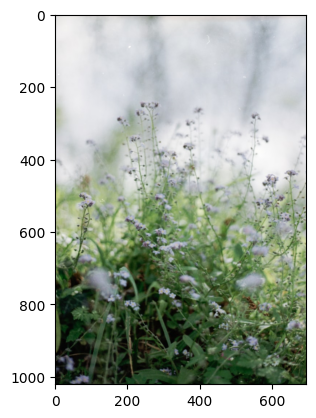

In [30]:
from urllib.request import urlretrieve
from PIL import Image
from matplotlib import pyplot as plt

# Save the background image
urlretrieve(background_url, background_file)
plt.imshow(Image.open(background_file))

In [38]:
import cv2
import numpy as np
import torch
from torchvision import transforms

def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # Split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # Add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # Merge the alpha channel back
  # plt.title('pic')
  # plt.imshow(pic)
  pic_with_alpha = cv2.merge([b, g, r, a], 4)
  # plt.title('pic with alpha')
  # plt.imshow(pic_with_alpha)
  # Create a transparent background
  bg = np.zeros(pic_with_alpha.shape)
  # Set up new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  print(f"Mask:\n{mask}")
  print(f"New Mask:\n{new_mask}")
  # Copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, pic_with_alpha, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.486, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.inference_mode():
    output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # Create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  print(f"output_predictions.byte():\n{output_predictions.byte()}")
  print(f"output_predictions.byte().shape:\n{mask.shape}")
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)
  plt.title("second bin_mask")
  plt.imshow(bin_mask)

  foreground = make_transparent_foreground(input_image, bin_mask)

  return foreground, bin_mask



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


output_predictions.byte():
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [8, 8, 8,  ..., 0, 0, 0],
        [8, 8, 8,  ..., 0, 0, 0],
        [8, 8, 8,  ..., 0, 0, 0]], dtype=torch.uint8)
output_predictions.byte().shape:
(469, 474)
Mask:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
New Mask:
[[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [  0   0   0   0]
  [  0  

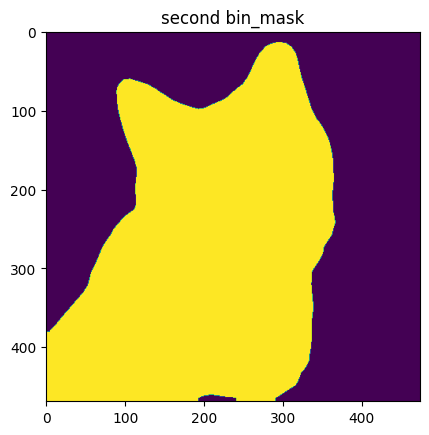

In [39]:
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, input_file)

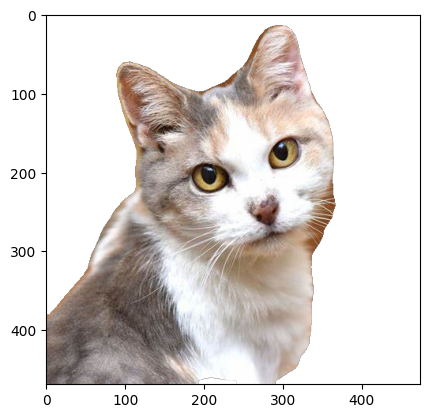

In [40]:
plt.imshow(foreground)

In [41]:
img_fg = Image.fromarray(foreground)
if foreground_file.endswith(('jpg', 'jpeg')):
  img_fg = img_fg.convert('RGB')

img_fg.save(foreground_file)

In [42]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0] - final_foreground.size[0]) / 2 + 0.5
  print(f"background.size[0]: {background.size[0]}")
  y = (background.size[1] - final_foreground.size[1]) / 2 + 0.5
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # Put the foreground in te centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)

  return final_image


background.size[0]: 695


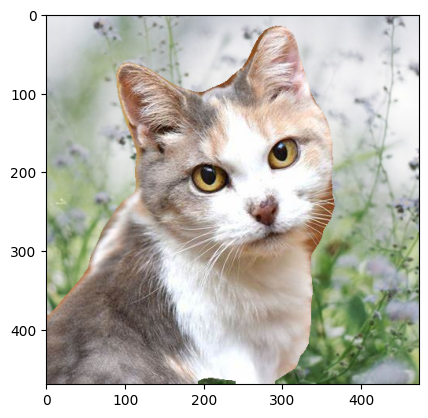

In [43]:
final_image = custom_background(background_file, foreground)
plt.imshow(final_image)


In [44]:
final_image.save(output_file)